# How the data looks like
```
station,date,element,value,qflag,mflag,sflag,
AE000041196,20210101,TMAX,278,,,S,
AE000041196,20210101,PRCP,0,D,,S,
AE000041196,20210101,TAVG,214,H,,S,
AEM00041194,20210101,TMAX,266,,,S,
AEM00041194,20210101,TMIN,178,,,S,
```

In [2]:
# imports
from pyspark.sql import SparkSession, functions, types, Row
import sys
assert sys.version_info >= (3, 5)
import re

# Configuration
## DataFrames
spark = SparkSession.builder.appName('Canadian wind').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '3.0'  # make sure we have Spark 3.0+
## RDDs
sc = spark.sparkContext
assert sc.version >= '3.0'

# General variables
data_path = "../data.nosync"

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/17 12:00:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/17 12:00:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Elements of interest
from the analysis, my elements or rather observations of interests are the following
TMAX = Maximum temperature (tenths of degrees C)
TMIN = Minimum temperature (tenths of degrees C)

AWDR = Average daily wind direction (degrees)
AWND = Average daily wind speed (tenths of meters per second)
DATN = Number of days included in the multiday minimum temperature (MDTN)
DATX = Number of days included in the multiday maximum temperature (MDTX)
DAWM = Number of days included in the multiday wind movement (MDWM)
FMTM = Time of fastest mile or fastest 1-minute wind (hours and minutes, i.e., HHMM)
MDTN = Multiday minimum temperature (tenths of degrees C; use with DATN)
MDTX = Multiday maximum temperature (tenths of degress C; use with DATX)
MDWM = Multiday wind movement (km)
TAVG = Average temperature (tenths of degrees C) (Note that TAVG from source 'S' corresponds to an average for the period ending at 2400 UTC rather than local midnight)
WDF1 = Direction of fastest 1-minute wind (degrees)
WDF2 = Direction of fastest 2-minute wind (degrees)
WDF5 = Direction of fastest 5-second wind (degrees)
WDFG = Direction of peak wind gust (degrees)
WDFI = Direction of highest instantaneous wind (degrees)
WDFM = Fastest mile wind direction (degrees)
WDMV = 24-hour wind movement (km)
WSF1 = Fastest 1-minute wind speed (tenths of meters per second)
WSF2 = Fastest 2-minute wind speed (tenths of meters per second)
WSF5 = Fastest 5-second wind speed (tenths of meters per second)
WSFG = Peak gust wind speed (tenths of meters per second)
WSFI = Highest instantaneous wind speed (tenths of meters per second)
WSFM = Fastest mile wind speed (tenths of meters per second)
WT** = Weather Type where ** has one of the following values:
  03 = Thunder
  07 = Dust, volcanic ash, blowing dust, blowing sand, or blowing obstruction
  08 = Smoke or haze
  09 = Blowing or drifting snow
  10 = Tornado, waterspout, or funnel cloud
  11 = High or damaging winds
  12 = Blowing spray
WV** = Weather in the Vicinity where ** has one of the following
       values:
   03 = Thunder
   07 = Ash, dust, sand, or other blowing obstruction

In [5]:
# wind speed in tenth of meters per second
wind_day_average_speed = "AWND"
wind_day_max_1min_speed = "WSF1"
wind_day_max_2min_speed = "WSF2"
wind_day_max_5min_speed = "WSF5"
wind_day_max_instantaneous_speed = "WSFI"
wind_day_peak_speed = "WSFG"
wind_speed = [
    wind_day_average_speed,
    wind_day_max_1min_speed,
    wind_day_max_2min_speed,
    wind_day_max_5min_speed,
    wind_day_max_instantaneous_speed,
    wind_day_peak_speed
]

# wind movement in km/h
wind_time_max_movement = "FMTM"
wind_multiday_movement = "MDWM"
wind_multiday_movement_number_of_days = "DAWM"
wind_day_movement = "WDMV"
wind_movement = [
    wind_time_max_movement,
    wind_multiday_movement,
    wind_multiday_movement_number_of_days,
    wind_day_movement
]

# wind directions in degree
wind_day_average_direction = "AWDR"
wind_day_max_1min_direction = "WDF1"
wind_day_max_2min_direction = "WDF2"
wind_day_max_5min_direction = "WDF5"
wind_day_peak_direction = "WDFG"
wind_day_max_instantaneous_direction = "WDFI"
wind_direction = [
    wind_day_average_direction,
    wind_day_max_1min_direction,
    wind_day_max_2min_direction,
    wind_day_max_5min_direction,
    wind_day_peak_direction,
    wind_day_max_instantaneous_direction
]

# temperature in tenths of degrees C
temperature_day_avg = "TAVG"
temperature_day_min = "TMIN"
temperature_multiday_min = "MDTN"
temperature_multiday_min_number_of_days = "DATN"
temperature_day_max = "TMAX"
temperature_multiday_max = "MDTX"
temperature_multiday_max_number_of_days = "DATX"
temperature = [
    temperature_day_avg,
    temperature_day_min,
    temperature_multiday_min,
    temperature_multiday_min_number_of_days,
    temperature_day_max,
    temperature_multiday_max,
    temperature_multiday_max_number_of_days
]

# wheather types
weather_thunder = "WT03"
weather_thunder_vicinity = "WV03"
weather_dust = "WT07"
weather_dust_vicinity = "WV07"
weather_smoke = "WT08"
weather_blowing_snow = "WT09"
weather_tornado = "WT10"
weather_damaging_winds = "WT11"
weather_blowing_spray = "WT12"
weather = [weather_thunder,
           weather_thunder_vicinity,
           weather_dust,
           weather_dust_vicinity,
           weather_smoke,
           weather_blowing_snow,
           weather_tornado,
           weather_damaging_winds,
           weather_blowing_spray
           ]

elements_of_interest = wind_speed + wind_direction + wind_movement + temperature + weather

### Group the data by states, because we want to find specific regions that are good for refugee settlement

In [3]:
stations = spark.read.parquet(data_path + "/ghcnd-stations-cleaned").withColumnRenamed("id", "station")
distinct_states_df = stations.select("state").distinct()
states = [row.state for row in distinct_states_df.collect()]
#stations.show()

def get_data_schema():
    return types.StructType([
        types.StructField('station', types.StringType()),
        types.StructField('date', types.StringType()),
        types.StructField('observation', types.StringType()),
        types.StructField('value', types.IntegerType()),
        types.StructField('mflag', types.StringType()),
        types.StructField('qflag', types.StringType()),
        types.StructField('sflag', types.StringType()),
        types.StructField('obstime', types.StringType()),
    ])

data = spark.read.csv(data_path + "/cluster-data", schema=get_data_schema())
cleaned_data = data.where(data["station"].startswith("CA"))
#cleaned_data.show()

merged = stations.join(cleaned_data, "station").select("station", "state", "date", "observation", "value", 'longitude', 'latitude').where(data["qflag"] != "null")

# only once:
merged.write.partitionBy("state", "observation").parquet(data_path + "/cluster-data-cleaned", mode="overwrite")

### Take only data including the observations that interest me


In [8]:
import os
base_path = data_path + "/cluster-data-cleaned/" # needed to get the columns back
for state in states:
    for observation in elements_of_interest:
        path = data_path + "/cluster-data-cleaned/state=" + state + "/observation=" + observation
        if os.path.isdir(path):
            data_of_interest = spark.read.format("parquet").option("basePath", base_path).load(path)
            data_of_interest.show()

+-----------+--------+-----+---------+--------+-----+-----------+
|    station|    date|value|longitude|latitude|state|observation|
+-----------+--------+-----+---------+--------+-----+-----------+
|CA008201969|20200101| 1300|   -61.05|   46.55|   NS|       WSFG|
|CA008201969|20200119| 1210|   -61.05|   46.55|   NS|       WSFG|
|CA008200558|20200207| 1180| -62.3333| 44.8167|   NS|       WSFG|
|CA008202000|20200207| 1170| -64.9167| 44.9833|   NS|       WSFG|
|CA008203478|20200207| 1160| -63.5333|    44.6|   NS|       WSFG|
|CA008206495|20200207| 1180| -66.0833| 43.8333|   NS|       WSFG|
|CA008201969|20200219| 1160|   -61.05|   46.55|   NS|       WSFG|
|CA008200558|20200509| 1150| -62.3333| 44.8167|   NS|       WSFG|
|CA008201969|20200830| 1170|   -61.05|   46.55|   NS|       WSFG|
|CA008201969|20200922| 1450|   -61.05|   46.55|   NS|       WSFG|
|CA008201780|20200923| 1190|   -60.65| 45.9167|   NS|       WSFG|
|CA008201969|20201123| 1220|   -61.05|   46.55|   NS|       WSFG|
|CA0082019

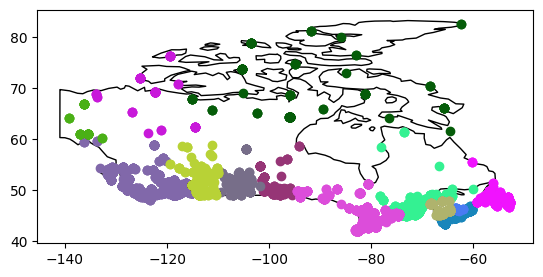

In [10]:
# Plot stations with pandas
import geopandas
import matplotlib.pyplot as plt
import numpy as np

# We restrict to Canada (other option: continent = "North America")
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.name == 'Canada'].plot(
    color='white', edgecolor='black')

for state in states:
    path = data_path + "/cluster-data-cleaned/state=" + state
    if os.path.isdir(path):
        data_of_interest = spark.read.format("parquet").option("basePath", base_path).load(path)
        data_of_interest_pd = data_of_interest.toPandas()
        gdf = geopandas.GeoDataFrame(
            data_of_interest_pd, geometry=geopandas.points_from_xy(data_of_interest_pd.longitude, data_of_interest_pd.latitude))
        gdf.plot(ax=ax, color=np.random.rand(3,))

plt.show()